# Notebook : Image Transformations

# Sommaire <a class="anchor" id="TOC"></a>
* [I)   Importations](#chapter1)
* [II)  Opération](#chapter2)
 
* [Fin](#END)

# I) Importations<a class="anchor" id="chapter1"></a>
* [Sommaire](#TOC)
## 1) Librairies

In [63]:
# A) Importations Librairies
## a) PATH
import sys
import os
## b) IMAGE
import pandas as pd
import scipy  as sc#Deprecated
import imageio
import numpy  as np  # USED
import PIL    as PIL # USED
import matplotlib       as mpl
import matplotlib.image as mpimg
## c) EXCEL
import openpyxl as openpyxl
## d) OTHERS
from tqdm.notebook import tqdm
all_libs = {
    "pandas"     : pd,
    "numpy"      : np,
    "matplotlib" : mpl,
    "PIL"        : PIL,
    "scipy"      : sc,
    "openpyxl"   : openpyxl,
}
for nom,lib in all_libs.items():
    print(f"{nom:-<16} : {lib.__version__}")
    
# B) Importations Fonction
from PIL import Image
from scipy import misc
from openpyxl import Workbook, load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill
from openpyxl.styles.colors import Color

pandas---------- : 1.4.2
numpy----------- : 1.21.5
matplotlib------ : 3.5.1
PIL------------- : 9.0.1
scipy----------- : 1.9.2
openpyxl-------- : 3.0.9


## 2) Paramètres
* [Sommaire](#TOC)
### A) PATH 

### B) IMAGE

In [64]:
class Pixel:        
    def __init__(self,rgba,a_init=255):
        rgba = [int(val) for val in rgba]
        self.r = rgba[0]
        self.g = rgba[1]
        self.b = rgba[2]
        self.a = rgba[3] if len(rgba)== 4 else a_init
        
        (r,g,b,a) = self.r,self.g,self.b,self.a
        
        self.tab = (r,g,b,a)
        self.dic = {"r":r,"g":g,"b":b,"a":a}
        
    
    def aRGB2hex(self):
        return f"{self.a:02x}{self.r:02x}{self.g:02x}{self.b:02x}"
    def RGB2hex(self):
        return f"{self.r:02x}{self.g:02x}{self.b:02x}"
    
    def rgb_equal(self,OtherPixel):
        return self.RGB2hex()  == OtherPixel.RGB2hex()
    def rgba_equal(self,OtherPixel):
        return self.aRGB2hex() == OtherPixel.aRGB2hex()
    def DicStr(self,rgba_mode=True):
        if rgba_mode:
            return self.dic
        else:
            return {i:j for i,j in self.dic.items() if i!='a'}
    def __str__(self):
        return self.aRGB2hex()
    
def ToPixel(r=0,g=0,b=0,a=0):
    return Pixel([r,g,b,a],a)

def GetInfoImage(image):
    return f"Format : {image.format} | Shape : {image.size} | Mode : {image.mode}"# Hauteur x Largeur x Pixel

def get_existing_color(im_np):
    list_rgba_color = []
    list_rgb_color  = []
    for hauteur in range(im_np.shape[0]):     # hauteur => row => y
        for largeur in range(im_np.shape[1]): # largeur => col => x
            if im_np.shape[2] == 4:
                r,g,b,a = tuple([im_np[hauteur,largeur,i] for i in range(4)]) 
            else:
                r,g,b = tuple([im_np[hauteur,largeur] for i in range(3)]) 
                a = 255
            pix = ToPixel(r,g,b,a)
            list_rgba_color.append(pix.aRGB2hex())  
            list_rgb_color.append(pix.RGB2hex())
    return set(list_rgba_color),set(list_rgb_color)
def check_existing_color(im_np,pixel_df):
    list_rgba_color,list_rgb_color  = get_existing_color(im_np)
    for i,pix_info in pixel_df.iterrows():
        res = (pix_info["Pixel_rgba"] in list_rgba_color,pix_info["Pixel_rgb"] in list_rgb_color)
        print(f"{pix_info['Type']:<15} | RGBA = {res[0]} | RGB = {res[1]}")

def Collision2Excel(im_np):
    LEN_CASE = 16
    MID_CASE = int(LEN_CASE/2)

    wb = Workbook()
    ws = wb.active

    for h_case,h_pix in enumerate(tqdm(np.arange(MID_CASE,im_np.shape[0],LEN_CASE)),1):
        for l_case,l_pix in enumerate(np.arange(MID_CASE,im_np.shape[1],LEN_CASE),1):
            pixel_case = Pixel(im_np[h_pix,l_pix,:],a_init=255)
            value_case_pixel = " "
            for i, pix_info in pixel_df.iterrows():
                if pixel_case.rgb_equal(pix_info['Pixel']):
                    ws.cell(row = h_case, column = l_case).value = pix_info['Case']
                    value_case_pixel=pix_info['Case']
                    break
            print(f"{value_case_pixel}",end="")
        print("\n",end="")
    return wb

In [65]:
typ_pix = \
{
    "mur"   : ToPixel(r=255),
    "eau"   : ToPixel(b=255),
    "herbe" : ToPixel(g=255),
    "marcheB" : ToPixel(r=80 ,g=20,b=20),
    "marcheH" : ToPixel(r=140,g=80,b=70),
    "Centre Pokemon" : ToPixel(r=232,g=144,b=112),
    "Boutique"       : ToPixel(r=48 ,g=96 ,b=160),
    "Arène"          : ToPixel(r=168,g=144,b=72),
    "TP"             : ToPixel(r=255,g=255,b=0),
}
typ_case = \
{
    "mur"   : ".",
    "eau"   : "~",
    "herbe" : "*",
    "marcheB" : "b",
    "marcheH" : "h",
    "Centre Pokemon" : "c",
    "Boutique"       : "s",
    "Arène"          : "a",
    "TP"             : "#",
}

cols = \
{
    "Type":[],
    "Case":[],
    "Pixel":[],
    "Pixel_rgb":[],
    "Pixel_rgba":[]
}

for typ in set(typ_pix.keys()) | set(typ_case.keys()):
    cols["Type"].append(typ)
    cols["Case"].append(typ_case.get(typ))
    cols["Pixel"].append(typ_pix.get(typ))
    cols["Pixel_rgb"].append(typ_pix.get(typ).RGB2hex())
    cols["Pixel_rgba"].append(typ_pix.get(typ).aRGB2hex())

pixel_df = pd.DataFrame(cols)

## II. Opération <a class="anchor" id="chapter2"></a>
* [Sommaire](#TOC)

In [66]:
Collison_PNG=[]
REP =  os.path.abspath(THIS_FOLDER+"/Image/Map/Collision")
for (repertoire, sousRepertoires, fichiers) in walk(REP):
    png_files=[os.path.join(repertoire, f) for f in fichiers if f[-4:].lower() == ".png"]
    Collison_PNG.extend(png_files)
Collison_PNG

['C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Foret\\foret_de_jade.png',
 'C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Routes\\route01.png',
 'C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Routes\\route02.png',
 'C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Routes\\route03.png',
 'C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Villes\\argenta.png',
 'C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Villes\\bourg-palette.png',
 'C:\\Users\\bapti\\OneDrive\\Bureau\\Game\\ExcelMon\\Image\\Map\\Collision\\Villes\\jadielle.png']


****************************************************************************************************

****************************************************************************************************

****************************************************************************************************
C:\Users\bapti\OneDrive\Bureau\Game\ExcelMon/Image/Map/Collision/Villes/bourg-palette.png
C:\Users\bapti\OneDrive\Bureau\Game\ExcelMon/ResultsTransformation/Map/Villes/bourg-palette.xlsx
IMAGE Format : PNG | Shape : (384, 320) | Mode : RGBA


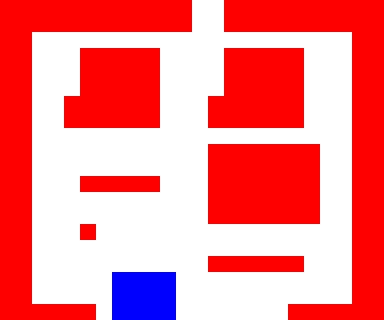

Image Transparence (Values[  0 255]) : 


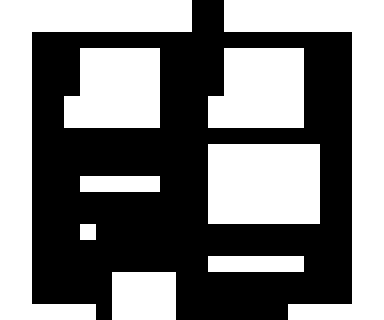

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = False
herbe           | RGBA = False | RGB = False
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = False
Arène           | RGBA = False | RGB = False
TP              | RGBA = False | RGB = False
eau             | RGBA = False | RGB = True
Boutique        | RGBA = False | RGB = False


  0%|          | 0/20 [00:00<?, ?it/s]

............  ..........
............  ..........
..                    ..
..   .....    .....   ..
..   .....    .....   ..
..   .....    .....   ..
..  ......   ......   ..
..  ......   ......   ..
..                    ..
..           .......  ..
..           .......  ..
..   .....   .......  ..
..           .......  ..
..           .......  ..
..   .                ..
..                    ..
..           ......   ..
..     ~~~~           ..
..     ~~~~           ..
...... ~~~~       ......

****************************************************************************************************

****************************************************************************************************

****************************************************************************************************
C:\Users\bapti\OneDrive\Bureau\Game\ExcelMon/Image/Map/Collision/Villes/jadielle.png
C:\Users\bapti\OneDrive\Bureau\Game\ExcelMon/ResultsTransformation/Map/Villes/jadielle.xlsx
IMAGE Format : PN

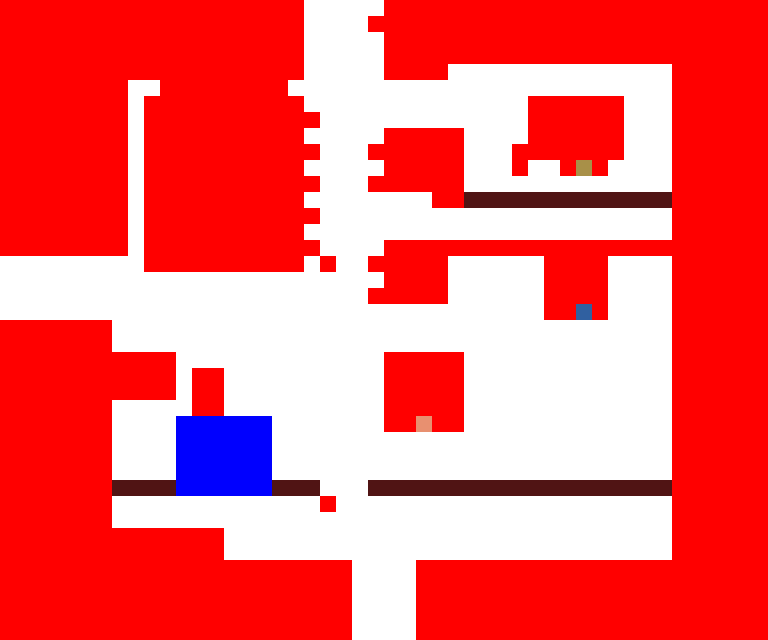

Image Transparence (Values[  0 255]) : 


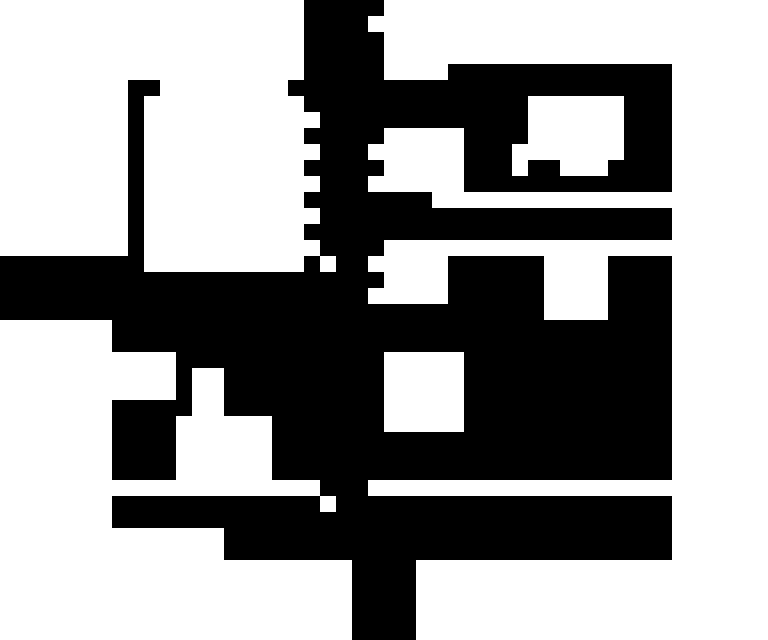

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = True
herbe           | RGBA = False | RGB = False
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = True
Arène           | RGBA = False | RGB = True
TP              | RGBA = False | RGB = False
eau             | RGBA = False | RGB = True
Boutique        | RGBA = False | RGB = True


  0%|          | 0/40 [00:00<?, ?it/s]

...................     ........................
...................    .........................
...................     ........................
...................     ........................
...................     ....              ......
........  ........                        ......
........ ..........              ......   ......
........ ...........             ......   ......
........ ..........     .....    ......   ......
........ ...........   ......   .......   ......
........ ..........     .....   .  .a.    ......
........ ...........   ......             ......
........ ..........        ..bbbbbbbbbbbbb......
........ ...........                      ......
........ ..........                       ......
........ ...........    ........................
         .......... .  .....      ....    ......
                        ....      ....    ......
                       .....      ....    ......
                                  ..s.    ......
.......             

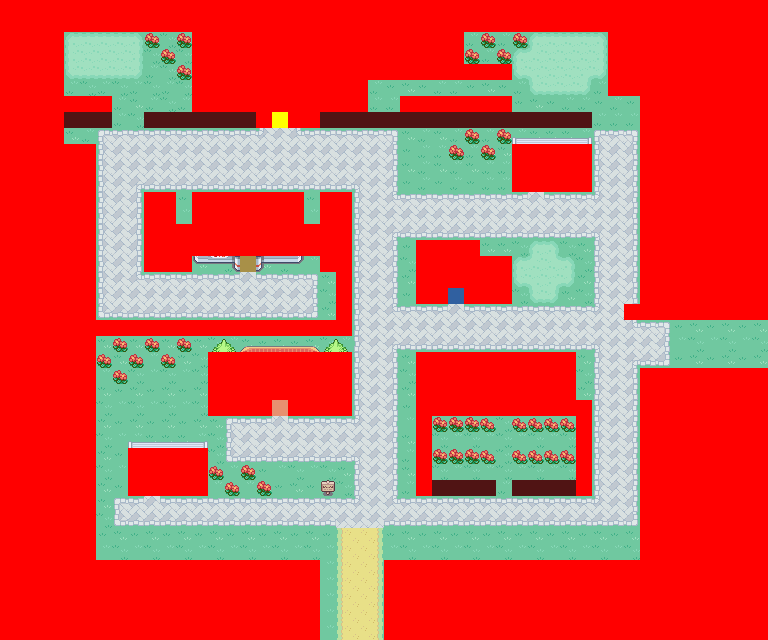

Image Transparence (Values[255]) : 


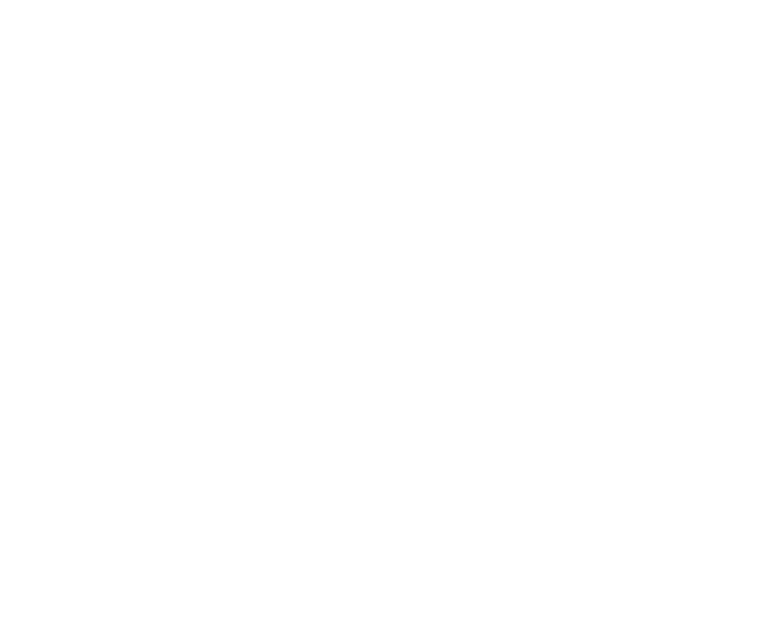

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = True
herbe           | RGBA = False | RGB = False
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = True
Arène           | RGBA = False | RGB = True
TP              | RGBA = False | RGB = True
eau             | RGBA = False | RGB = False
Boutique        | RGBA = False | RGB = True


  0%|          | 0/40 [00:00<?, ?it/s]

................................................
................................................
....        .................         ..........
....        .................         ..........
....        ....................      ..........
....        ...........               ..........
.......     ...........  .......        ........
....bbb  bbbbbbb.#..bbbbbbbbbbbbbbbbb   ........
....                                    ........
......                          .....   ........
......                          .....   ........
......                          .....   ........
......   .. ....... ..                  ........
......   .. ....... ..                  ........
......   .............                  ........
......   .............    ....          ........
......   ...   a    ..    ......        ........
......               .    ......        ........
......               .    ..s...        ........
......               .                 .........
....................

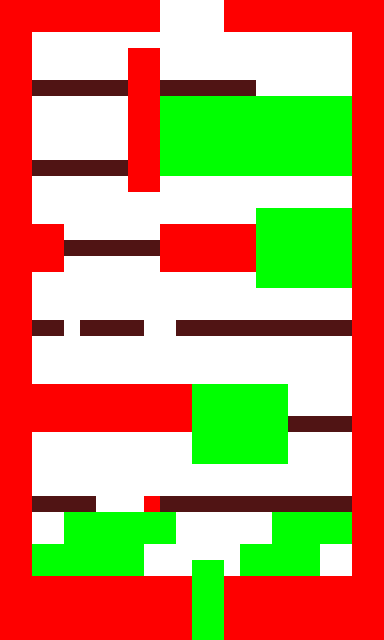

Image Transparence (Values[  0 255]) : 


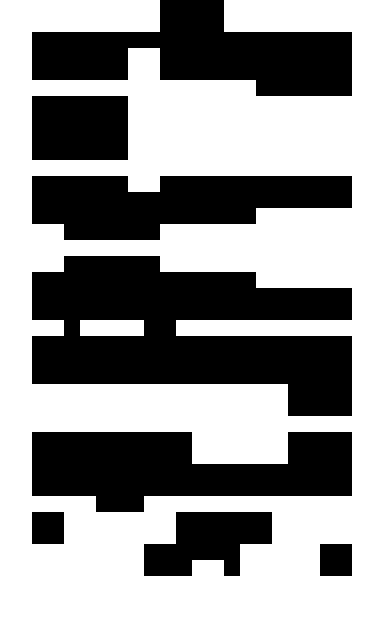

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = False
herbe           | RGBA = False | RGB = True
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = True
Arène           | RGBA = False | RGB = False
TP              | RGBA = False | RGB = False
eau             | RGBA = False | RGB = False
Boutique        | RGBA = False | RGB = False


  0%|          | 0/40 [00:00<?, ?it/s]

..........    ..........
..........    ..........
..                    ..
..      ..            ..
..      ..            ..
..bbbbbb..bbbbbb      ..
..      ..************..
..      ..************..
..      ..************..
..      ..************..
..bbbbbb..************..
..      ..            ..
..                    ..
..              ******..
....      ......******..
....bbbbbb......******..
....      ......******..
..              ******..
..                    ..
..                    ..
..bb bbbb  bbbbbbbbbbb..
..                    ..
..                    ..
..                    ..
............******    ..
............******    ..
............******bbbb..
..          ******    ..
..          ******    ..
..                    ..
..                    ..
..bbbb   .bbbbbbbbbbbb..
..  *******      *****..
..  *******      *****..
..*******      *****  ..
..*******   ** *****  ..
............**..........
............**..........
............**..........
............**..........


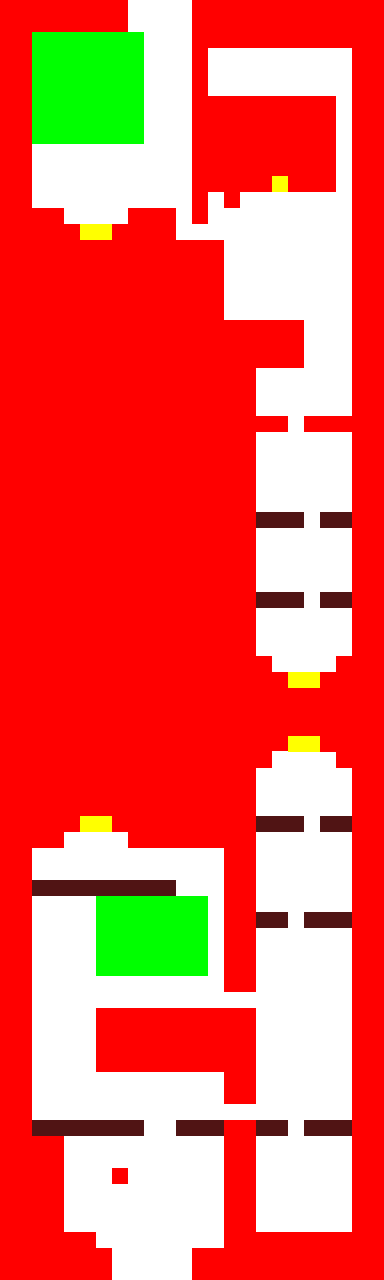

Image Transparence (Values[  0 255]) : 


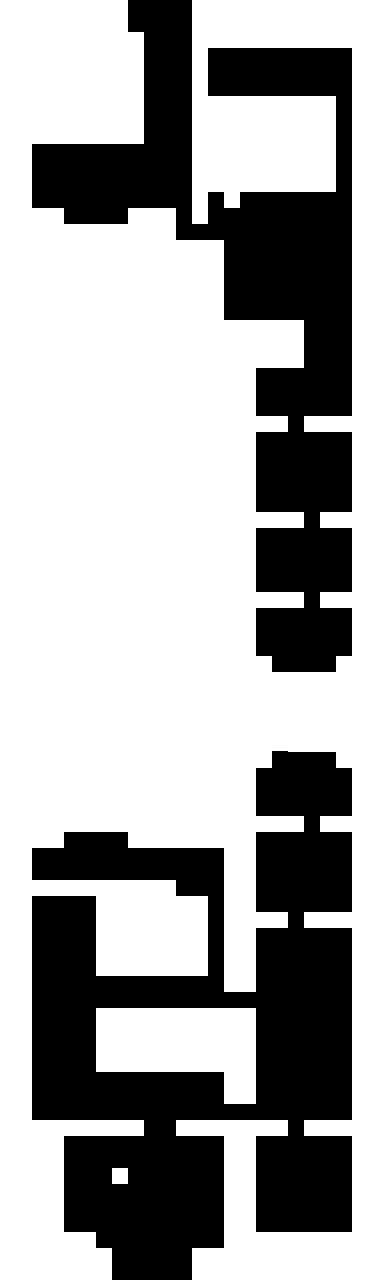

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = False
herbe           | RGBA = False | RGB = True
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = True
Arène           | RGBA = False | RGB = False
TP              | RGBA = False | RGB = True
eau             | RGBA = False | RGB = False
Boutique        | RGBA = False | RGB = False


  0%|          | 0/80 [00:00<?, ?it/s]

........    ............
........    ............
..*******   ............
..*******   .         ..
..*******   .         ..
..*******   .         ..
..*******   ......... ..
..*******   ......... ..
..*******   ......... ..
..          ......... ..
..          ......... ..
..          .....#... ..
..          . .       ..
....    ... .         ..
.....##....           ..
..............        ..
..............        ..
..............        ..
..............        ..
..............        ..
...................   ..
...................   ..
...................   ..
................      ..
................      ..
................      ..
.................. .....
................      ..
................      ..
................      ..
................      ..
................      ..
................bbb bb..
................      ..
................      ..
................      ..
................      ..
................bbb bb..
................      ..
................      ..


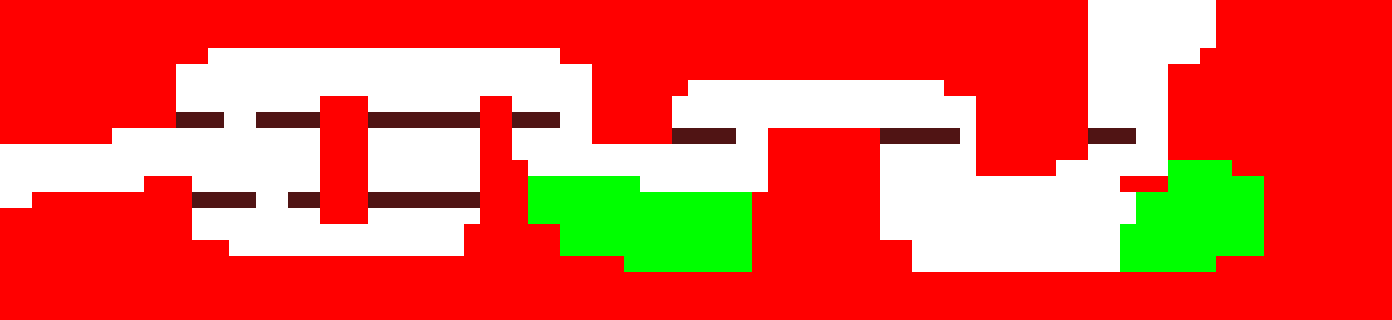

Image Transparence (Values[  0 255]) : 


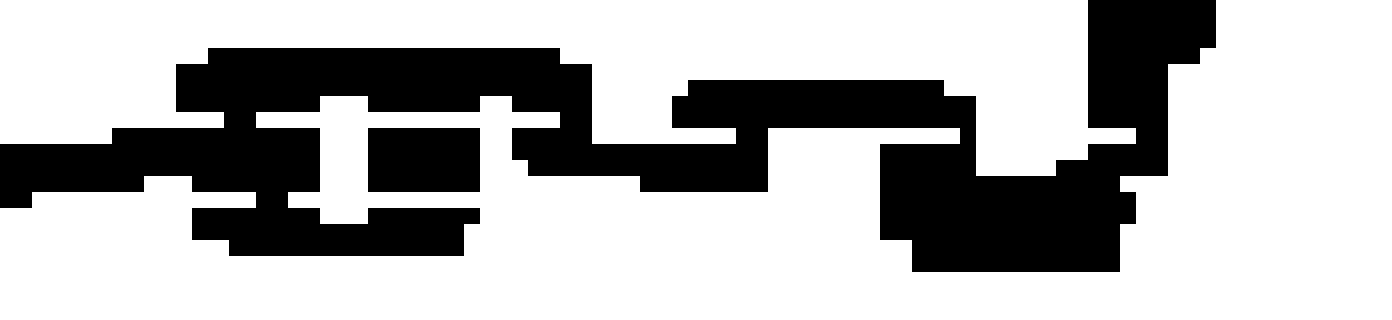

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = False
herbe           | RGBA = False | RGB = True
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = True
Arène           | RGBA = False | RGB = False
TP              | RGBA = False | RGB = False
eau             | RGBA = False | RGB = False
Boutique        | RGBA = False | RGB = False


  0%|          | 0/20 [00:00<?, ?it/s]

....................................................................        ...........
....................................................................        ...........
....................................................................        ...........
.............                      .................................       ............
...........                          ...............................     ..............
...........                          ......                .........     ..............
...........         ...       ..     .....                   .......     ..............
...........bbb  bbbb...bbbbbbb..bbb  .....                   .......     ..............
.......             ...       ..     .....bbbb  .......bbbbb .......bbb  ..............
                    ...       ..                .......      .......     ..............
                    ...       ...               .......      .....       ****..........
         ...        ...       ..

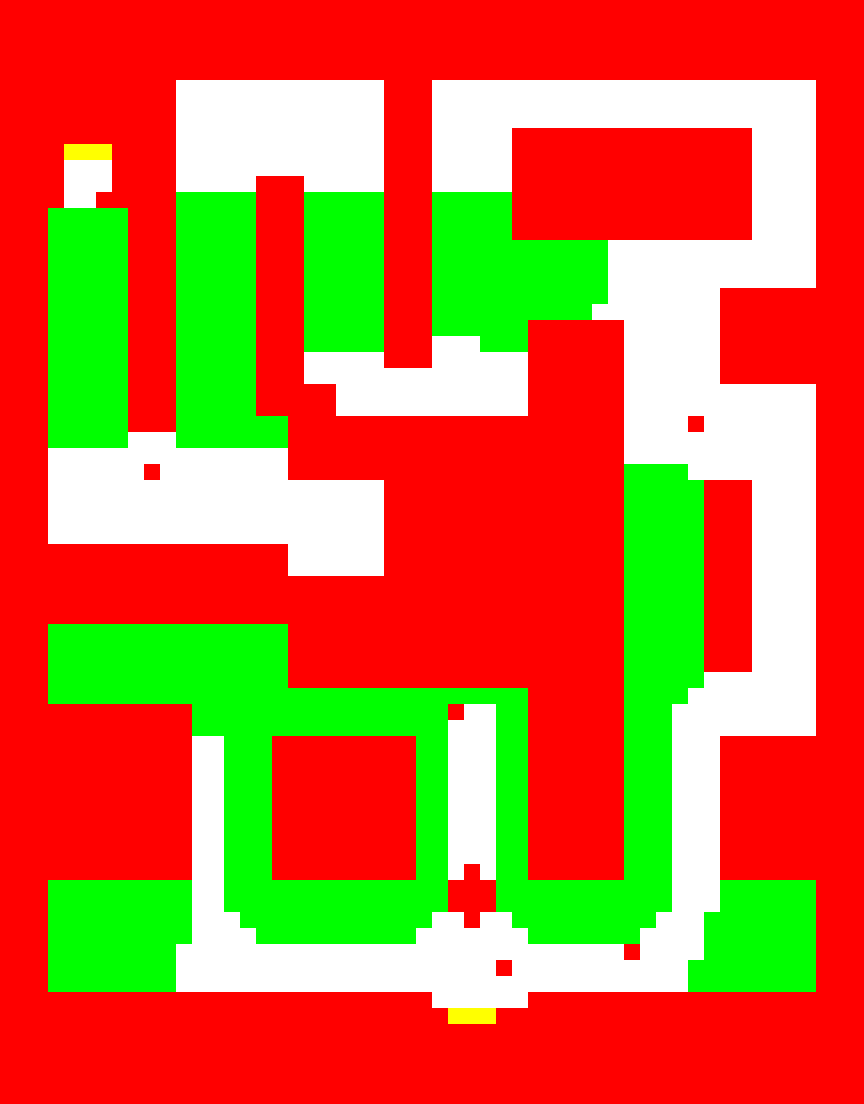

Image Transparence (Values[  0 255]) : 


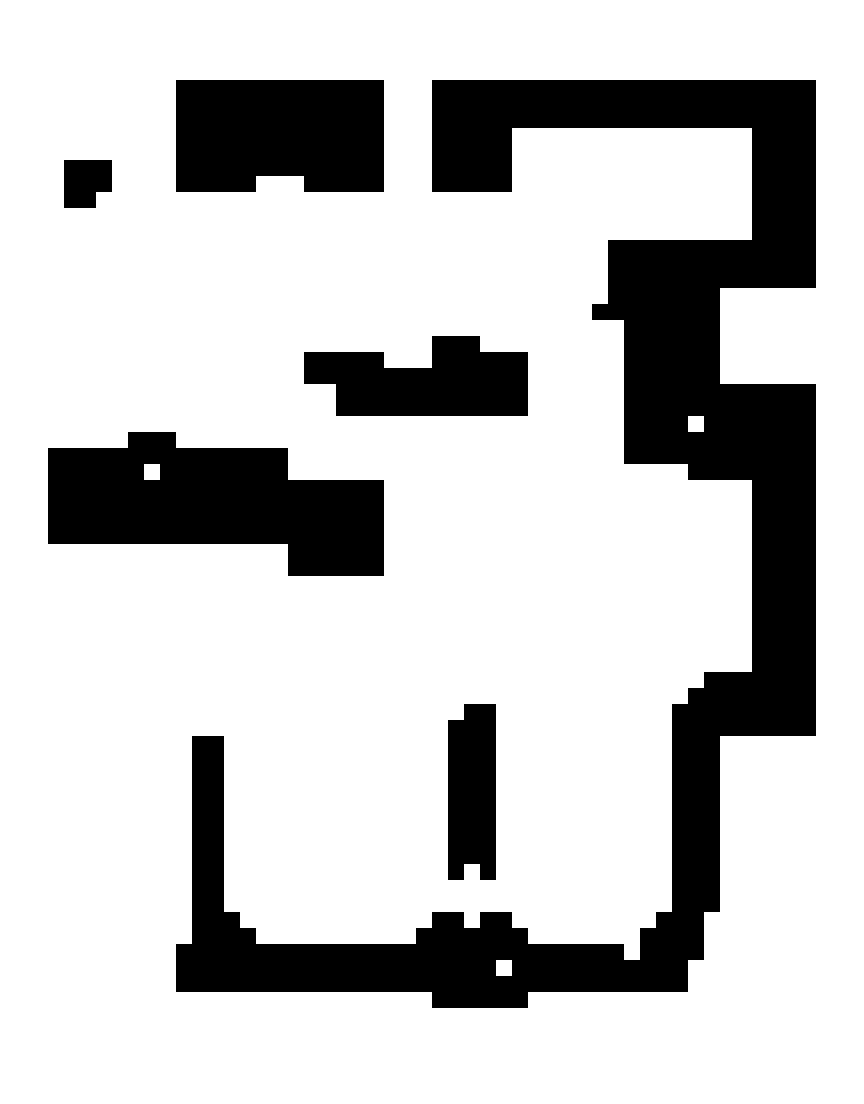

Précense :
mur             | RGBA = False | RGB = True
Centre Pokemon  | RGBA = False | RGB = False
herbe           | RGBA = False | RGB = True
marcheH         | RGBA = False | RGB = False
marcheB         | RGBA = False | RGB = False
Arène           | RGBA = False | RGB = False
TP              | RGBA = False | RGB = True
eau             | RGBA = False | RGB = False
Boutique        | RGBA = False | RGB = False


  0%|          | 0/69 [00:00<?, ?it/s]

......................................................
......................................................
......................................................
......................................................
......................................................
...........             ...                        ...
...........             ...                        ...
...........             ...                        ...
...........             ...     ...............    ...
....###....             ...     ...............    ...
....   ....             ...     ...............    ...
....   ....     ...     ...     ...............    ...
....  .....*****...*****...*****...............    ...
...*****...*****...*****...*****...............    ...
...*****...*****...*****...*****...............    ...
...*****...*****...*****...***********             ...
...*****...*****...*****...***********             ...
...*****...*****...*****...***********             ...
...*****..

In [67]:
THIS_FOLDER = os.path.abspath('.')
FOLDER_EXCEL = "/ResultsTransformation/Map/"
FORMAT_EXCEL = ".xlsx"
FOLDER_IMAGE_PATH = \
{
    "/Image/Map/Collision/Villes/" : 
    [
        "bourg-palette",
        "jadielle",
        "argenta"
    ],
    "/Image/Map/Collision/Routes/" : 
    [
        "route01",
        "route02",
        "route03"
    ],
     "/Image/Map/Collision/Foret/" : 
    [
        "foret_de_jade"
    ],
}
FORMAT_IMAGE = ".png"

for FOLDER_IMAGE,NAME_IMAGE_LIST in FOLDER_IMAGE_PATH.items():
    for NAME_IMAGE in NAME_IMAGE_LIST:
        print("\n" + "".join(["*"]*100))
        print("\n" + "".join(["*"]*100))
        print("\n" + "".join(["*"]*100))
        PATH_IMAGE = THIS_FOLDER + FOLDER_IMAGE + NAME_IMAGE + FORMAT_IMAGE
        TYPE_IMAGE = os.path.basename(os.path.dirname(PATH_IMAGE)) +"/"
        PATH_EXCEL = THIS_FOLDER + FOLDER_EXCEL + TYPE_IMAGE + NAME_IMAGE + FORMAT_EXCEL
        if not os.path.exists(os.path.dirname(PATH_EXCEL)):
            os.makedirs(os.path.dirname(PATH_EXCEL))
        print(PATH_IMAGE)
        print(PATH_EXCEL)
        NAME_EXCEL = NAME_IMAGE
        
        im    = Image.open(PATH_IMAGE)
        im_np = np.asarray(im, dtype=int)

        print(f"IMAGE {GetInfoImage(im)}")# Hauteur x Largeur x Pixel
        display(im)
        if im.mode == "RGBA":
            (r, g, b, a) = im.split()
            print(f"Image Transparence (Values{np.unique(np.asarray(a))}) : ")
            display(a)
        print("Précense :")
        check_existing_color(im_np,pixel_df)
            
        wb = Collision2Excel(im_np)
        wb.active.title = NAME_EXCEL
        wb.save(PATH_EXCEL)

# END <a class="anchor" id="END"></a>
* [Sommaire](#TOC)